In [1]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
q = '''select * from package_usage pu
join package p on pu.package_id = p.id'''
usage = pd.DataFrame(sql.execute(q))

In [3]:
q ='''select distinct a.id as advisory_id, a.severity, a.disclose_date, a.publish_date,
        CWE, p.id as package_id, p.name, p.ecosystem, p.repository_url,
        ri.id as release_id, ri.version, ri.prior_release, ri.publish_date as release_date
from advisory a
join package p on a.package_id = p.id
join advisoryCWE aC on a.id = aC.advisory_id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on ri.package_id = p.id
    and ri.version = fr.version
where ri.prior_release is not null
and ri.prior_release != 'manual checkup needed'
    and ri.prior_release != 'branch does not match'
    and ri.prior_release != 'not valid semver formatting'
    and repository_url != 'no repository listed' '''
df = pd.DataFrame(sql.execute(q))
df['advisory_id'].nunique(), df['package_id'].nunique(), df['release_id'].nunique()

(3520, 1725, 3856)

In [4]:
q ='''select distinct a.id as advisory_id, a.severity, a.disclose_date, a.publish_date,
        CWE, p.id as package_id, p.name, p.ecosystem, p.repository_url,
        ri.id as release_id, ri.version, ri.prior_release, ri.publish_date as release_date
from advisory a
join package p on a.package_id = p.id
join advisoryCWE aC on a.id = aC.advisory_id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on ri.package_id = p.id
    and ri.version = fr.version
where ri.prior_release is not null
and ri.prior_release != 'manual checkup needed'
    and ri.prior_release != 'branch does not match'
    and ri.prior_release != 'not valid semver formatting'
    and repository_url != 'no repository listed'
and (ri.id in (select distinct release_id from version_diff)
or (ri.id in (select release_id from version_diff_with_no_package_file ))
) '''
df = pd.DataFrame(sql.execute(q))
df['advisory_id'].nunique(), df['package_id'].nunique(), df['release_id'].nunique()

(3082, 1542, 3355)

In [5]:
q ='''select *
from advisory a
join package p on a.package_id = p.id
join advisoryCWE aC on a.id = aC.advisory_id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on ri.package_id = p.id
    and ri.version = fr.version
join rq3 on rq3.release_id = ri.id
join release_type rt on rt.release_info_id = rq3.release_id
where ri.prior_release is not null
and ri.prior_release != 'manual checkup needed'
    and ri.prior_release != 'branch does not match'
    and ri.prior_release != 'not valid semver formatting'
    and repository_url != 'no repository listed'
    and files_changed > 0 '''
df = pd.DataFrame(sql.execute(q))
df['advisory_id'].nunique(), df['package_id'].nunique(), df['release_id'].nunique()

(2940, 1460, 3151)

In [6]:
q ='''select distinct ecosystem, release_id, rt.type, ri.version
from advisory a
join package p on a.package_id = p.id
join advisoryCWE aC on a.id = aC.advisory_id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on ri.package_id = p.id
    and ri.version = fr.version
join rq3 on rq3.release_id = ri.id
join release_type rt on rt.release_info_id = rq3.release_id
where ri.prior_release is not null
and ri.prior_release != 'manual checkup needed'
    and ri.prior_release != 'branch does not match'
    and ri.prior_release != 'not valid semver formatting'
    and repository_url != 'no repository listed'
    and files_changed > 0 '''
rt = pd.DataFrame(sql.execute(q))
total_count = len(rt)
total = rt.groupby('ecosystem')[['release_id']].count()

# patch release
p = rt[(rt['type']=='patch') & (~rt['version'].str.startswith('0'))]
all_p = round((len(p)/total_count) * 100 , 1)
all_p = str(all_p) + '%'
p = p.groupby('ecosystem')[['release_id']].count()
p = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[total, p])
p['patch'] = round(p['release_id_y']/p['release_id_x']*100, 1)
p['patch'] = p['patch'].map(str) + '%'


b = rt[(rt['type']=='major') & (~rt['version'].str.startswith('0'))]
all_b = round((len(b)/total_count) * 100 , 1)
all_b = str(all_b) + '%'
b = b.groupby('ecosystem')[['release_id']].count()
b = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[total, b])
b['breaking'] = round(b['release_id_y']/b['release_id_x']*100, 1)
b['breaking'] = b['breaking'].map(str) + '%'

u = rt[rt['version'].str.startswith('0')]
all_u = round((len(u)/total_count) * 100 , 1)
all_u = str(all_u) + '%'
u = u.groupby('ecosystem')[['release_id']].count()
u = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[total, u])
u['unstable'] = round(u['release_id_y']/u['release_id_x']*100, 1)
u['unstable'] = u['unstable'].map(str) + '%'



p = p.drop(['release_id_y', 'release_id_x'], axis=1)
b = b.drop(['release_id_y', 'release_id_x'], axis=1)
u = u.drop(['release_id_y', 'release_id_x'], axis=1)

len(rt[rt['type']=='minor']), len(rt[rt['type']=='prerelease'])

(456, 158)

In [7]:
All = ['All', df['advisory_id'].nunique(), df['package_id'].nunique(), df['cwe'].nunique(), df['release_id'].nunique(), all_p, all_b, all_u]
All

['All', 2940, 1460, 152, 3151, '66.5%', '2.5%', '10.9%']

In [8]:
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')[['release_id']].nunique()
cwe = df.groupby('ecosystem')[['cwe']].nunique()

In [9]:
q = '''select *
from rq3
join release_info ri on rq3.release_id = ri.id
join package p on ri.package_id = p.id
where files_changed > 0;'''
df = pd.DataFrame(sql.execute(q))

In [10]:
All.append(df['files_changed'].median())
All.append(df['loc_changed'].median())

In [11]:

file = df.groupby('ecosystem')[['files_changed']].median()
loc = df.groupby('ecosystem')[['loc_changed']].median()
final = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, cwe, rel, p, b, u, file, loc])

final = final.reset_index()
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop(['temp'], axis=1)
final.loc[len(final)] = All
final


,ecosystem,advisory_id,package_id,cwe,release_id,patch,breaking,unstable,files_changed,loc_changed
0,Composer,742,198,63,784,85.3%,0.4%,1.8%,11.0,212.0
1,Go,145,109,42,164,62.2%,1.8%,23.8%,3.0,59.0
2,Maven,589,293,77,754,66.8%,1.2%,3.1%,13.0,326.5
5,npm,690,486,79,734,54.6%,6.9%,19.1%,3.0,58.0
3,NuGet,190,44,20,110,87.3%,0.9%,2.7%,17.0,447.0
6,pip,381,218,68,340,44.7%,1.2%,25.9%,7.0,146.0
4,RubyGems,203,112,46,265,64.5%,3.0%,13.6%,3.0,34.0
7,All,2940,1460,152,3151,66.5%,2.5%,10.9%,6.0,134.0


In [12]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrlllrr}
\hline
 ecosystem   &   advisory\_id &   package\_id &   cwe &   release\_id & patch   & breaking   & unstable   &   files\_changed &   loc\_changed \\
\hline
 Composer    &           742 &          198 &    63 &          784 & 85.3\%   & 0.4\%       & 1.8\%       &              11 &         212   \\
 Go          &           145 &          109 &    42 &          164 & 62.2\%   & 1.8\%       & 23.8\%      &               3 &          59   \\
 Maven       &           589 &          293 &    77 &          754 & 66.8\%   & 1.2\%       & 3.1\%       &              13 &         326.5 \\
 npm         &           690 &          486 &    79 &          734 & 54.6\%   & 6.9\%       & 19.1\%      &               3 &          58   \\
 NuGet       &           190 &           44 &    20 &          110 & 87.3\%   & 0.9\%       & 2.7\%       &              17 &         447   \\
 pip         &           381 &          218 &    68 &          340 & 44.7\%   & 1.2\%       & 25.9

In [13]:
usage = pd.merge(df, usage, on=['package_id', 'ecosystem'])
from scipy.stats import spearmanr
from scipy.stats import pearsonr
ecosystems = ['Composer','Go','Maven','npm','NuGet','pip','RubyGems']
l=[]
newl = []
for ecosystem in ecosystems:
    temp = usage[usage['ecosystem'] ==  ecosystem ]
    a = spearmanr(temp['loc_changed'], temp['dependent'])
    b = spearmanr(temp['loc_changed'], temp['dependent_repos'])
    l.append([ecosystem, a ,b])
    newl.append([ecosystem, round(a[0],2), round(b[0],2)])

l.append(['All', spearmanr(usage['loc_changed'], usage['dependent']), spearmanr(usage['loc_changed'], usage['dependent_repos'])])
newl.append(['All', round(spearmanr(usage['loc_changed'], usage['dependent'])[0],2), round(spearmanr(usage['loc_changed'], usage['dependent_repos'])[0],2)])
l

[['Composer',
  SpearmanrResult(correlation=-0.08694596560271879, pvalue=0.014882916275405136),
  SpearmanrResult(correlation=-0.15165071676992686, pvalue=2.0068198434656007e-05)],
 ['Go',
  SpearmanrResult(correlation=0.009493874138997051, pvalue=0.9542572756401946),
  SpearmanrResult(correlation=0.06837483531957764, pvalue=0.6791724394865579)],
 ['Maven',
  SpearmanrResult(correlation=0.12771247136830427, pvalue=0.0004390072269949952),
  SpearmanrResult(correlation=0.07185147075355425, pvalue=0.0485810558614503)],
 ['npm',
  SpearmanrResult(correlation=0.04807241460957095, pvalue=0.19328200264525455),
  SpearmanrResult(correlation=-0.0002754043537874706, pvalue=0.9940568858572636)],
 ['NuGet',
  SpearmanrResult(correlation=-0.06585997878238982, pvalue=0.4942295002074737),
  SpearmanrResult(correlation=-0.004263285838138396, pvalue=0.9647424883587852)],
 ['pip',
  SpearmanrResult(correlation=0.03622675714322836, pvalue=0.5074705146136597),
  SpearmanrResult(correlation=0.0390647542412

In [14]:
newl =  pd.DataFrame(newl, columns=['Ecosytem', 'Dependent Packages', 'Dependent Repositories'])
print(tabulate(newl, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrr}
\hline
 Ecosytem   &   Dependent Packages &   Dependent Repositories \\
\hline
 Composer   &                -0.09 &                    -0.15 \\
 Go         &                 0.01 &                     0.07 \\
 Maven      &                 0.13 &                     0.07 \\
 npm        &                 0.05 &                    -0    \\
 NuGet      &                -0.07 &                    -0    \\
 pip        &                 0.04 &                     0.04 \\
 RubyGems   &                -0.11 &                    -0.18 \\
 All        &                -0.02 &                    -0.09 \\
\hline
\end{tabular}


In [15]:
unstable = df[df['version'].str.startswith('0')]
unstable['files_changed'].median(), unstable['loc_changed'].median()

(4.0, 77.0)

In [16]:
temp = df.copy()
temp['ecosystem'] = "All"
temp = pd.concat([temp, df], axis=0)

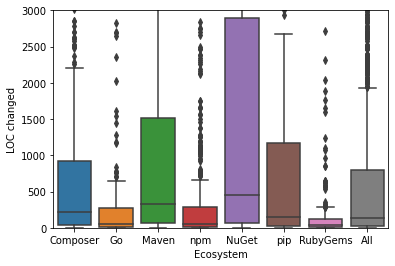

In [17]:
ax = sns.boxplot(y='loc_changed', x='ecosystem', data = temp, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems', 'All'])
ax.set(ylim=(0,3000), xlabel='Ecosystem', ylabel='LOC changed')
plt.savefig('loc_change.png',bbox_inches='tight')

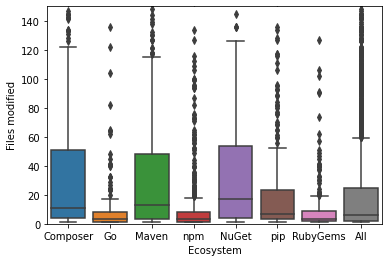

In [18]:
ax = sns.boxplot(y='files_changed', x='ecosystem', data = temp, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems', 'All'])
ax.set(ylim=(0,150), xlabel='Ecosystem', ylabel='Files modified')
plt.savefig('files_change.png',bbox_inches='tight')

In [19]:
q ='''
select *
from rq3
join
(select  release_id, max(severity) as severity
from
    (select a.id as advisory_id, ri.id as release_id,
       case
            when severity='H' then 3
           when severity='M' then 2
           when severity='L' then 1
        end as severity
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version) sub
group by release_id) sub2
on rq3.release_id=sub2.release_id
where files_changed > 0;
'''
df = pd.DataFrame(sql.execute(q))
df['release_id'].nunique()

3151

In [20]:
# TODO take the highest severity for a security release
high, medium, low = df[df['severity']==3], df[df['severity']==2], df[df['severity']==1]
high['loc_changed'].describe(), medium['loc_changed'].describe(), low['loc_changed'].describe()

(count    1.498000e+03
 mean     5.654734e+03
 std      6.600301e+04
 min      2.000000e+00
 25%      2.800000e+01
 50%      1.385000e+02
 75%      7.557500e+02
 max      2.376380e+06
 Name: loc_changed, dtype: float64,
 count    1.529000e+03
 mean     4.292723e+03
 std      5.298426e+04
 min      1.000000e+00
 25%      2.400000e+01
 50%      1.280000e+02
 75%      7.810000e+02
 max      1.977516e+06
 Name: loc_changed, dtype: float64,
 count      124.000000
 mean      3619.024194
 std      10692.306838
 min          2.000000
 25%         40.250000
 50%        121.000000
 75%       1209.250000
 max      70946.000000
 Name: loc_changed, dtype: float64)

In [21]:
from scipy.stats import mannwhitneyu
mannwhitneyu(high['loc_changed'],medium['loc_changed']), mannwhitneyu(high['loc_changed'],low['loc_changed']), mannwhitneyu(medium['loc_changed'],low['loc_changed'])

(MannwhitneyuResult(statistic=1138268.5, pvalue=0.38621942444769825),
 MannwhitneyuResult(statistic=87721.0, pvalue=0.1518757485082316),
 MannwhitneyuResult(statistic=88715.5, pvalue=0.11706563188872388))

In [22]:
high, medium, low = df[df['severity']==3], df[df['severity']==2], df[df['severity']==1]
high['files_changed'].describe(), medium['files_changed'].describe(), low['files_changed'].describe()

(count     1498.000000
 mean        81.025367
 std        489.168160
 min          1.000000
 25%          2.000000
 50%          6.000000
 75%         26.750000
 max      12490.000000
 Name: files_changed, dtype: float64,
 count    1529.000000
 mean       47.869196
 std       161.567445
 min         1.000000
 25%         2.000000
 50%         6.000000
 75%        25.000000
 max      2707.000000
 Name: files_changed, dtype: float64,
 count    124.000000
 mean      65.830645
 std      161.042625
 min        1.000000
 25%        3.000000
 50%        7.000000
 75%       26.500000
 max      835.000000
 Name: files_changed, dtype: float64)

In [23]:
from scipy.stats import mannwhitneyu
mannwhitneyu(high['files_changed'],medium['files_changed']), mannwhitneyu(high['files_changed'],low['loc_changed']), mannwhitneyu(medium['loc_changed'],low['loc_changed'])

(MannwhitneyuResult(statistic=1139807.0, pvalue=0.4106150222513168),
 MannwhitneyuResult(statistic=29217.5, pvalue=1.8264375065533552e-37),
 MannwhitneyuResult(statistic=88715.5, pvalue=0.11706563188872388))

In [24]:
q='''select *
from rq3
join
(select  release_id, max(ifcve) as ifcve
from
    (select a.id as advisory_id, ri.id as release_id,
       case
            when a.id in (select advisory_id from advisoryCVE) then 1
           else 0
        end as ifcve
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version) sub
group by release_id) sub2
on rq3.release_id=sub2.release_id
where files_changed > 0;'''
df = pd.DataFrame(sql.execute(q))
df['release_id'].nunique()

3151

In [25]:
df = pd.DataFrame(sql.execute(q))
df['release_id'].nunique()

3151

In [26]:
cve, noncve = df[df['ifcve']==1], df[df['ifcve']==0]
cve['loc_changed'].describe(), noncve['loc_changed'].describe()

(count    2.384000e+03
 mean     4.282615e+03
 std      5.237606e+04
 min      1.000000e+00
 25%      2.675000e+01
 50%      1.330000e+02
 75%      7.930000e+02
 max      2.376380e+06
 Name: loc_changed, dtype: float64,
 count    7.670000e+02
 mean     6.875319e+03
 std      7.479949e+04
 min      2.000000e+00
 25%      2.700000e+01
 50%      1.380000e+02
 75%      7.900000e+02
 max      1.977516e+06
 Name: loc_changed, dtype: float64)

In [27]:
mannwhitneyu(cve['loc_changed'],noncve['loc_changed'])

MannwhitneyuResult(statistic=907348.5, pvalue=0.3761760159139267)

In [28]:
cve, noncve = df[df['ifcve']==1], df[df['ifcve']==0]
cve['files_changed'].describe(), noncve['files_changed'].describe()

(count     2384.000000
 mean        64.207634
 std        356.037205
 min          1.000000
 25%          2.000000
 50%          6.000000
 75%         26.000000
 max      12490.000000
 Name: files_changed, dtype: float64,
 count     767.000000
 mean       64.745763
 std       361.394629
 min         1.000000
 25%         2.000000
 50%         6.000000
 75%        23.500000
 max      6993.000000
 Name: files_changed, dtype: float64)

In [29]:
mannwhitneyu(cve['files_changed'],noncve['files_changed'])

MannwhitneyuResult(statistic=895142.5, pvalue=0.19066848377059292)